# Visualización de Información en Python

> **Autor** \
> Eduardo Graells-Garrido \
> Instituto de Data Science UDD \
> Telefónica I+D Chile \
> egraells@udd.cl \
> @carnby

## Sesión 2: Visualización de Tablas

> **Caso de Estudio** \
> Data Set: Encuesta de Viajes (Origen-Destino) de Santiago, 2012 \
> Diplomado en Data Science UDD

## Introducción

En la sesión anterior cargamos la encuesta origen-destino de Santiago y realizamos un análisis exploratorio, más que dirigido a los datos, enfocado en ver las posibilidades de visualización incorporadas en `pandas` y en las bibliotecas `matplotlib` y `seaborn`.

En esta sesión continuaremos el análisis, esta vez enfocándonos en la unidad de _Visualización de Tablas_ que vimos en el módulo teórico del curso.

### Lo que Haremos 

En este ejercicio:

  1. Cargaremos datos de la encuesta, disponible en el [Portal de Datos del Gobierno](http://datos.gob.cl/dataset/31682), en un DataFrame de `pandas`. 
  2. Utilizaremos BoxPlot para visualizar distribuciones.
  3. Utilizaremos Stacked (Normalized) Bar Charts para ver distribuciones relativas.
  4. Utilizaremos Heatmaps y Slope Charts para analizar comportamiento grupal y generar matrices origen-destino.

### Preámbulo

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

%matplotlib inline
sns.set(context='notebook', font='Fira Sans', style='white', palette='plasma')

In [2]:
path = './EOD_STGO'

Definimos algunas funciones auxiliares:

  - `decode_column` nos permite descodificar los valores de una columna con aquellos que aparecen en una tabla auxiliar (como las que están en la carpeta `Tablas_parametros`).
  - `normalize_rows` toma un DataFrame, que se asume que tiene solamente columnas numéricas, y entrega un nuevo DataFrame con el mismo índice y mismas columnas, pero los valores de cada fila suman 1.0.
  - `normalize_columns` lo mismo que la función anterior, pero para columnas.

In [3]:
import numpy as np

def decode_column(df, fname, col_name, index_col='Id', value_col=None, sep=';', encoding='utf-8', index_dtype=np.float64):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: index_dtype}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

def normalize_rows(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def normalize_columns(df):
    df = pd.DataFrame(normalize(df, norm='l1', axis=0), index=df.index, columns=df.columns)
    return df

## Carga de Datos y Exploración

Repetiremos algunas operaciones del notebook anterior, así que avanzaremos más rápido en esta sección.

In [4]:
personas = pd.read_csv(path + '/personas.csv', sep=';', decimal=',', encoding='utf-8')
personas['Sexo'] = decode_column(personas, path + '/Tablas_parametros/Sexo.csv', 'Sexo')
personas['TramoIngreso'] = decode_column(personas, path + '/Tablas_parametros/TramoIngreso.csv', 'TramoIngreso')
personas['Relacion'] = decode_column(personas,path + '/Tablas_parametros/Relacion.csv', 'Relacion', value_col='relacion')
personas['Ocupacion'] = decode_column(personas,path + '/Tablas_parametros/Ocupacion.csv', 'Ocupacion', value_col='ocupacion')

In [5]:
hogares = pd.read_csv(path + '/Hogares.csv', sep=';', decimal=',', encoding='utf-8')
hogares['Sector'] = decode_column(hogares, path + '/Tablas_parametros/Sector.csv', 'Sector')

Crucemos la tabla de personas con la de hogares (**nota**: ¡el orden importa!). Como ambas tablas tienen una columna `Factor`, les cambiaremos el nombre para evitar confusiones.

In [6]:
personas_hogar = personas.rename(columns={'Factor': 'FactorPersona'}).merge(hogares.rename(columns={'Factor': 'FactorHogar'}))

Cargaremos la tabla de viajes, y dos tablas auxiliares. Noten los parámetros `index_col='Viaje'`: indican que, de las columnas de la tabla, la columna `Viaje` será usada como índice (o llave, o identificador) de cada fila. 

Hacemos de una vez el cruce con las tablas auxiliares con el método `join`, que funciona sobre los índices de las tablas que une: si dos filas comparten índice, son unidas.

In [7]:
viajes = (pd.read_csv(path + '/viajes.csv', sep=';', decimal=',', index_col='Viaje')
          .join(pd.read_csv(path + '/ViajesDifusion.csv', sep=';', index_col='Viaje'))
          .join(pd.read_csv(path + '/DistanciaViaje.csv', sep=';', index_col='Viaje')))
viajes.head()

,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,...,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada
Viaje,,,,,,,,,,,,,,,,,,,,,
1734310202,173431,17343102,1,94.0,94.0,2.0,2.0,400,407,335208.7188,...,1.000000,NaN,NaN,NaN,NaN,0.0,2,5387,7608,0
1734410101,173441,17344101,2,94.0,71.0,2.0,3.0,407,307,338536.4375,...,1.127220,NaN,NaN,NaN,NaN,0.0,2,18841,26100,0
1734410102,173441,17344101,2,71.0,94.0,3.0,2.0,307,407,354267.3438,...,1.127220,NaN,NaN,NaN,NaN,0.0,2,18841,26100,0
1734410301,173441,17344103,2,94.0,91.0,2.0,3.0,407,437,338536.4375,...,1.127220,NaN,NaN,NaN,NaN,0.0,2,13392,17589,0
1734410302,173441,17344103,2,91.0,94.0,3.0,2.0,437,407,350841.6563,...,1.052764,NaN,NaN,NaN,NaN,0.0,2,13392,17589,0


Decodificaremos algunas columnas que utilizaremos en el análisis:

In [8]:
viajes['ModoDifusion'] = decode_column(viajes, path + '/Tablas_parametros/ModoDifusion.csv', 'ModoDifusion', encoding='latin-1',
                                       index_col='ID')
viajes['Proposito'] = decode_column(viajes, path + '/Tablas_parametros/Proposito.csv', col_name='Proposito')
viajes['SectorOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', 
                                       col_name='SectorOrigen', index_col='Sector', value_col='Nombre', sep=';')
viajes['SectorDestino'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', 
                                       col_name='SectorDestino', index_col='Sector', value_col='Nombre', sep=';')
viajes['ComunaOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaOrigen', 
                                       value_col='Comuna', sep=',')
viajes['ComunaDestino'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaDestino', 
                                       value_col='Comuna', sep=',')
viajes['Periodo'] = decode_column(viajes, path + '/Tablas_parametros/Periodo.csv', 'Periodo', 
                                  sep=';', value_col='Periodos')

Ahora juntaremos todos los datos en una única tabla, `viajes_persona`. Usaremos el método `merge`:

In [9]:
viajes_persona = viajes.merge(personas_hogar)
viajes_persona.head()

,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,...,NumVeh,NumBicAdulto,NumBicNino,Propiedad,MontoDiv,ImputadoDiv,MontoArr,ImputadoArr,IngresoHogar,FactorHogar
0,173431,17343102,1,Maipú,Maipú,Poniente,Poniente,400,407,335208.7188,...,0,0,0,2,81067.0,1,120000,0,789356,76.81028
1,173431,17343102,1,Maipú,Maipú,Poniente,Poniente,407,400,338812.2813,...,0,0,0,2,81067.0,1,120000,0,789356,76.81028
2,173441,17344101,2,Maipú,Las Condes,Poniente,Oriente,407,307,338536.4375,...,0,0,0,2,57000.0,0,140000,0,633883,76.81028
3,173441,17344101,2,Las Condes,Maipú,Oriente,Poniente,307,407,354267.3438,...,0,0,0,2,57000.0,0,140000,0,633883,76.81028
4,173441,17344103,2,Maipú,Ñuñoa,Poniente,Oriente,407,437,338536.4375,...,0,0,0,2,57000.0,0,140000,0,633883,76.81028


Finalmente, nos interesaremos solamente en el área urbana de Santiago. Con el siguiente código dejamos viajes que sean relevantes para el estudio:

In [10]:
# primero, descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
viajes_persona = viajes_persona[(viajes_persona['SectorOrigen'] != 'Exterior a RM') 
                & (viajes_persona['SectorDestino'] != 'Exterior a RM')
                & (viajes_persona['SectorOrigen'] != 'Extensión Sur-Poniente') 
                & (viajes_persona['SectorDestino'] != 'Extensión Sur-Poniente')
                & pd.notnull(viajes_persona['SectorOrigen'])
                & pd.notnull(viajes_persona['SectorDestino'])
                # también descartamos viajes que hayan sido imputados en la encuesta
                & (viajes_persona['Imputada'] == 0)
                # y finalmente descartamos viajes cuya distancia indique que son viajes cortísimos o bien demasiado largos para el tamaño de la ciudad
                & (viajes_persona['DistManhattan'].between(500, 35000))]


print(len(viajes_persona))

77383


Comencemos :)

---

## 1. BoxPlot para Distribuciones

En la clase pasada graficamos directamente las distribuciones de algunas variables, utilizando el método `sns.distplot`. Ahora bien, no siempre la distribución tiene una forma adecuada para su visualización directa. Veamos una pregunta de ejemplo:

#### ¿Cuál es la distribución del ingreso en los hogares por Sector?

Si conocemos Santiago, sabemos que el sector oriente tiene mayor ingreso promedio que el resto. Esto debiese ser evidente en un gráfico que nos muestre esas distribuciones.

Si utilizamos una _Kernel Density Estimation_ (como hace el método `sns.distplot`), veremos una aproximación de la distribución. Mezclando `sns.distplot` y `sns.FacetGrid` para dibujar la distribución de cada sector, obtenemos lo siguiente:

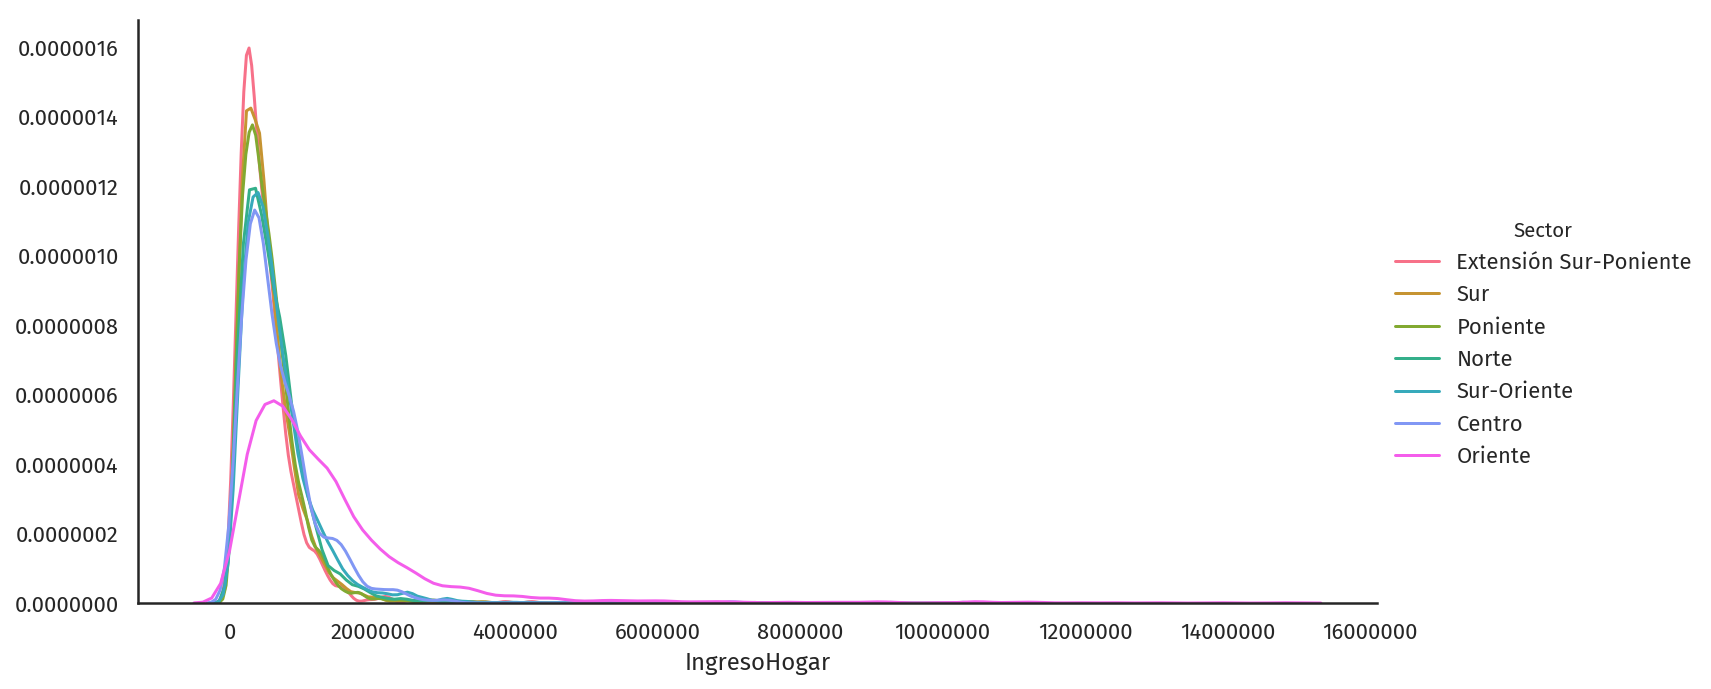

In [11]:
g = sns.FacetGrid(data=hogares, aspect=2, hue='Sector', height=5, palette='husl')
# no grafiquemos los histogramas, solamente la función de densidad
g.map(sns.distplot, 'IngresoHogar', hist=False)
# esto muestra cada valor en el eje X sin abreviación o notación científica
g.ax.ticklabel_format(style='plain')
g.add_legend()

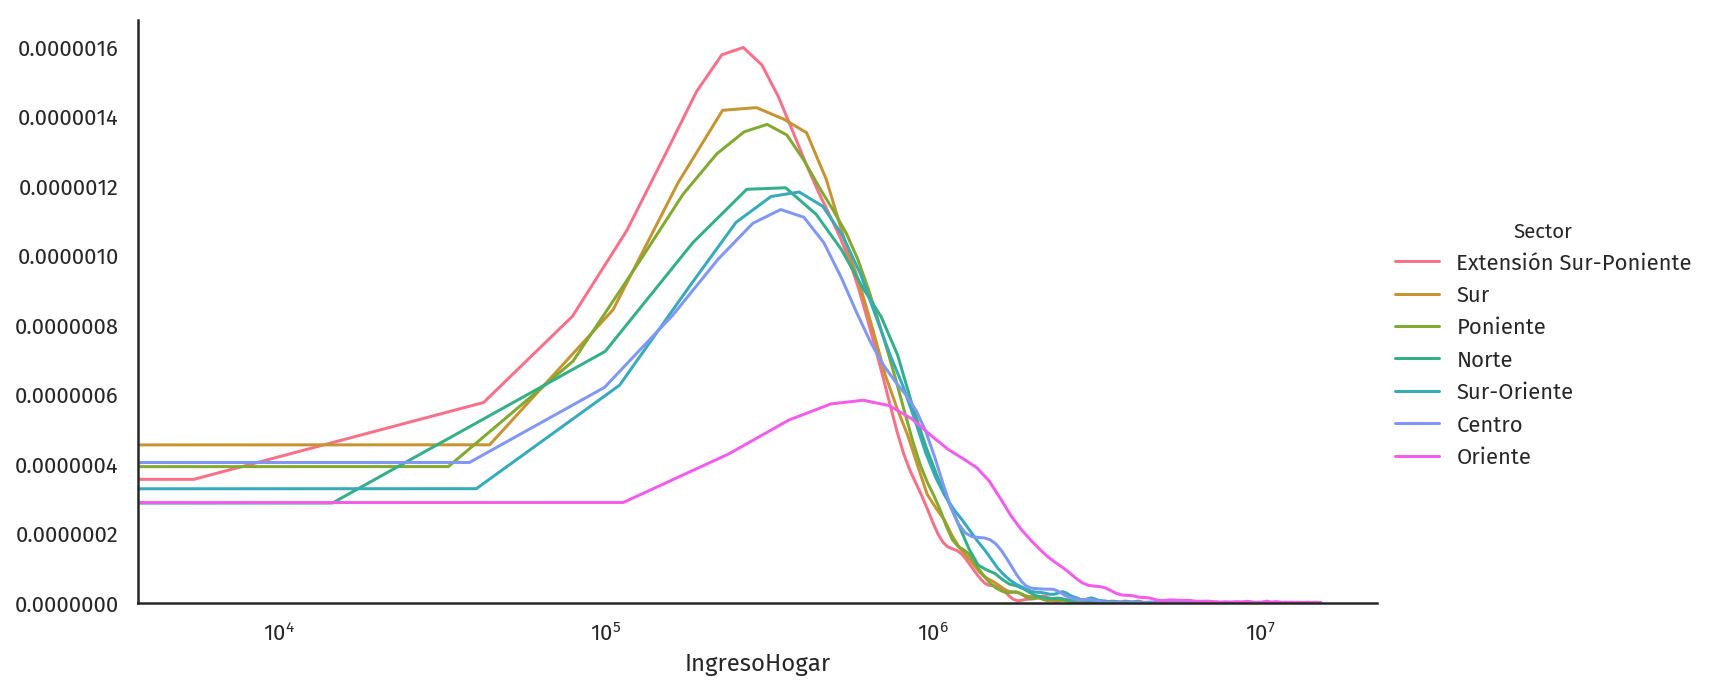

In [12]:
g = sns.FacetGrid(data=hogares, aspect=2, hue='Sector', height=5, palette='husl')
g.map(sns.distplot, 'IngresoHogar', hist=False)
# esto cambia la escala en el eje X del gráfico
# la escala log nos permite apreciar mejor la distribución cuando está sesgada
g.set(xscale='log')
g.add_legend()

En ambos casos observamos que el sector oriente tiene una distribución diferente a la de los otros sectores de la ciudad. Y sabemos que tiene mayor ingreso. Sin embargo, al no tener distribuciones normales, los gráficos no nos permiten ver fácilmente valores de la distribución como la mediana y los cuartiles de la distribución.

Aquí podemos utilizar `sns.boxplot`, que permite ver esos atributos de la distribución:

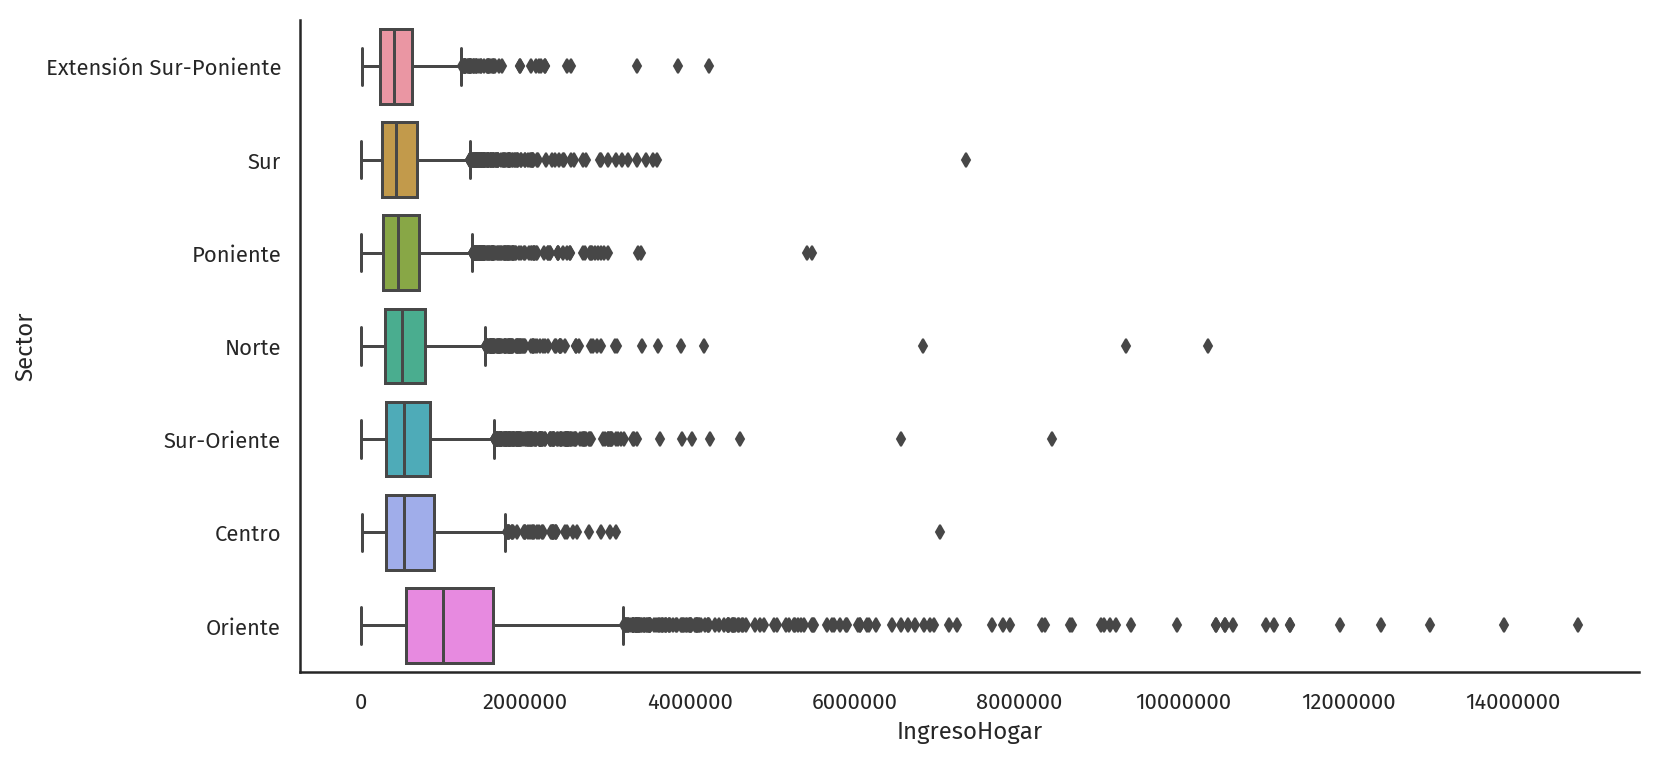

In [13]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(y='Sector', x='IngresoHogar', data=hogares)
ax.ticklabel_format(style='plain', axis='x')
sns.despine()

Los diamantes que se ven en el gráfico son hogares _outlier_, que, en este caso, ganan mucho más que el resto de la distribución. Podemos omitirlos con el parámetro `showfliers=False`:

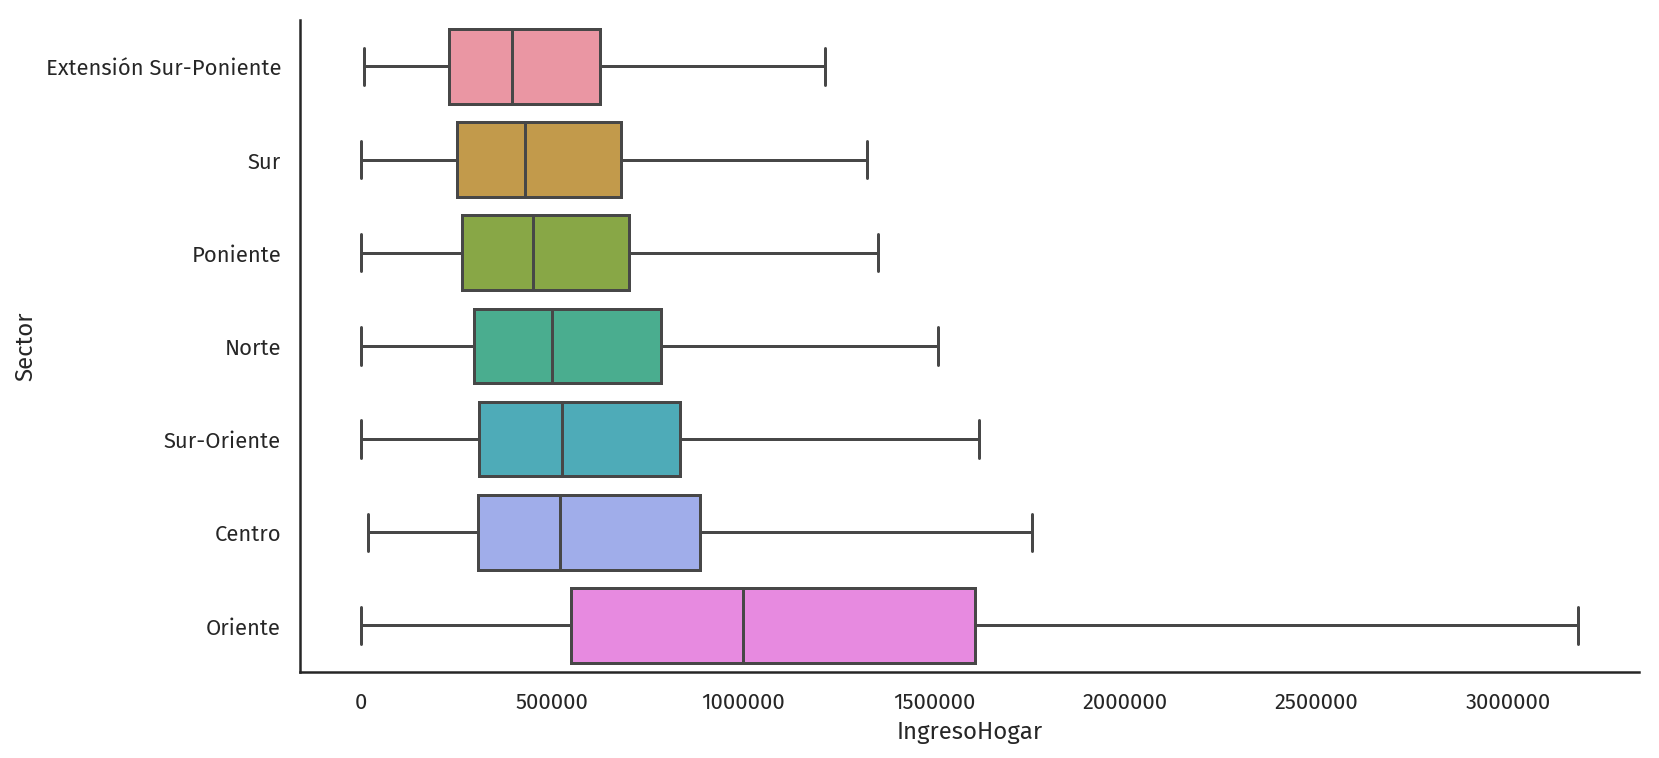

In [14]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(y='Sector', x='IngresoHogar', data=hogares, showfliers=False)
ax.ticklabel_format(style='plain', axis='x')
sns.despine()

¡Con esto podemos hacer comparaciones directas entre un sector y otro! Como vimos en clase, los _boxplots_ no son la panacea, pero sí que son útiles. Por eso se siguen usando.

**NOTA**: El análisis anterior **no** usa factores de expansión, por tanto, no es un análisis del que podamos extraer resultados significativos. Lo hemos realizado a manera de exposición del uso de _boxplot_.

---

## 2. Stacked (Normalized) Bar Charts para ver Distribuciones Relativas

### ¿A qué hora viaja la gente de acuerdo al propósito del viaje?

1. Elegimos los propósitos que queremos visualizar.
1. Filtramos los viajes, dejando solamente aquellos que tengan un factor de expansión en día laboral 
2. Agrupamos los viajes de cada Periodo del día y cada PropositoAgregado
  - A cada uno de esos grupos les calculamos el total de viajes, definido como el factor de expansión del viaje multiplicado por el factor de expansión de la persona. Multiplicamos los elementos de las dos columnas del grupo.
  - luego sumamos todos los resultados
  - Este resultado nos da una Serie que contiene un índice de dos columnas (Periodo, PropositoAgregado) y una columna con valores, que contiene la suma calculada antes.
3. Construimos una matriz con estos valores, haciendo que el índice sea cada valor de Periodo y las columnas cada valor de PropositoAgregado.
  - Como no todas las combinaciones Periodo,PropositoAgregado existen, quedan algunos valores nulos en la matriz.
  - Normalizamos cada fila de la matriz, para tener la distribución
  - Ordenamos la matriz de acuerdo a alguna columna específica
4. realizamos un gráfico de barras apiladas

#### Propósitos y viajes en día laboral

In [15]:
viajes_persona['Proposito'].unique()

array(['volver a casa', 'Visitar a alguien', 'Al trabajo',
       'Buscar o Dejar a alguien', 'Al estudio', 'De compras',
       'Otra actividad (especifique)', 'Recreación', 'De salud',
       'Trámites', 'Por estudio', 'Comer o Tomar algo', 'Por trabajo',
       'Buscar o dejar algo', nan], dtype=object)

In [16]:
from collections import defaultdict

propositos_agregados = defaultdict(lambda: 'Otro')

propositos_agregados.update({
    'Al estudio': 'Estudio',
    'Al trabajo': 'Trabajo',
    'Por estudio': 'Estudio',
    'Por trabajo': 'Trabajo',
    'volver a casa': 'Volver a Casa',
    'De salud': 'Necesidades',
    'De compras': 'Necesidades',
    'Trámites': 'Necesidades'
})

In [17]:
viajes_persona['PropositoAgregado'] = viajes_persona['Proposito'].map(lambda x: propositos_agregados[x])

Para estructurar nuestro análisis, utilizaremos la técnica `method chaining` en `pandas`. Es una manera de expresar múltiples operaciones en los datos. Pueden ver más información en [este link](https://tomaugspurger.github.io/method-chaining).

In [18]:
viajes_persona['PesoLaboral'] = viajes_persona['FactorLaboralNormal'] * viajes_persona['FactorPersona']
viajes_persona['PesoLaboral'].sample(5)

54723         NaN
43356         NaN
82355         NaN
71871    96.75038
38780         NaN
Name: PesoLaboral, dtype: float64

In [19]:
viajes_persona['PesoLaboral'].sum()

8122419.21136257

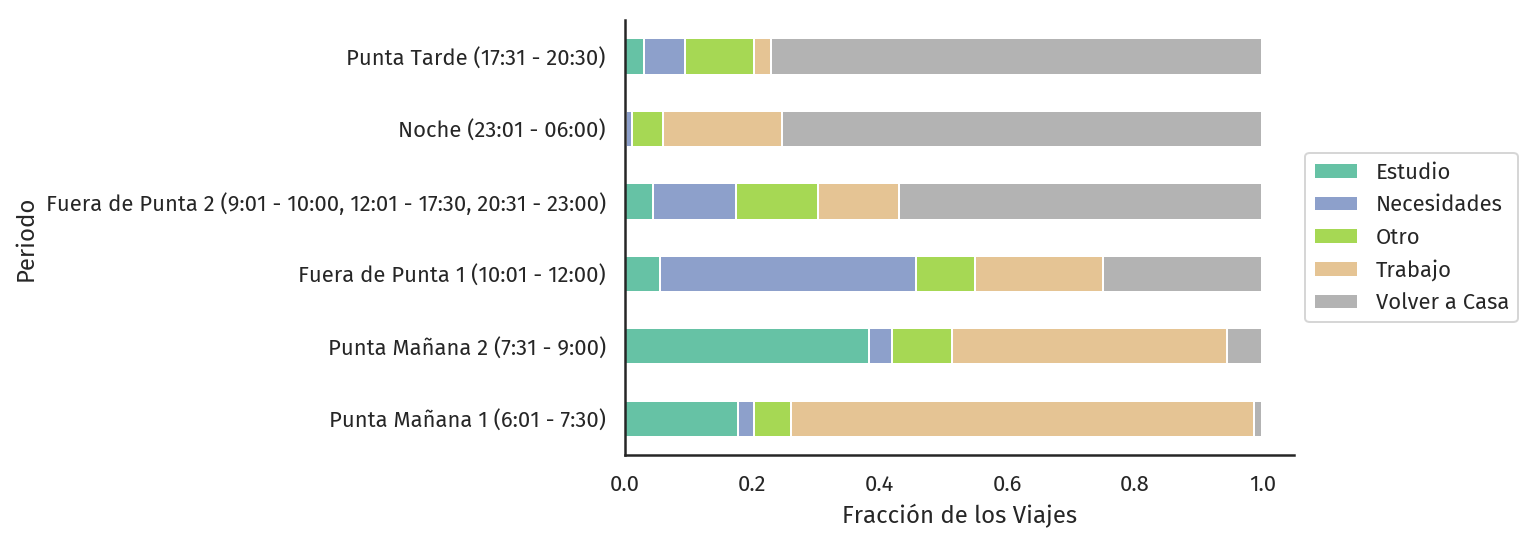

In [20]:
# primero, ponemos un paréntesis para poder escribir múltiples líneas de código como si fueran una sola
(viajes_persona
 # luego, filtramos los viajes, dejando solamente aquellos que tengan un factor de expansión en día laboral 
 [pd.notnull(viajes_persona.PesoLaboral)]
 # agrupamos los viajes de cada Periodo del día y cada PropositoAgregado
 .groupby(['Periodo', 'PropositoAgregado'])
 # y luego los sumamos. El resultado quedará en una columna n_viajes
 .agg(n_viajes=('PesoLaboral', 'sum'))
 # este resultado nos da una Serie que contiene un índice de dos columnas (Periodo, PropositoAgregado)
 # y una columna con valores, que contiene la suma calculada antes
 # con este método construimos una matriz con estos valores
 # haciendo que el índice sea cada valor de Periodo
 # y las columnas cada valor de PropositoAgregado
 # no todas las combinaciones Periodo,PropositoAgregado existen
 # por lo que quedan algunos valores nulos en la matriz.
 # con esto, llenamos esos valores con 0
 ['n_viajes'].unstack(fill_value=0)
 # normalizamos cada fila de la matriz, para tener la distribución
 .pipe(normalize_rows)
 # opcionalmente, ordenamos la matriz de acuerdo a alguna columna específica
 .sort_values('Volver a Casa')
 # realizamos un gráfico de barras apiladas
 .plot(kind='barh', stacked=True, cmap='Set2')
)

# con esto acomodamos la leyenda para que no obstruya el gráfico
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Fracción de los Viajes')
sns.despine()

### ¿Usan las mujeres los mismos modos de transporte que los hombres?

Podemos aplicar el mismo esquema del gráfico anterior para responder esta pregunta, que vimos de manera exploratoria en la clase pasada. Esta vez sí usaremos los factores de expansión.

A diferencia de la pregunta anterior, usaremos todos los viajes. Nos enfocaremos en el factor de cada persona solamente.

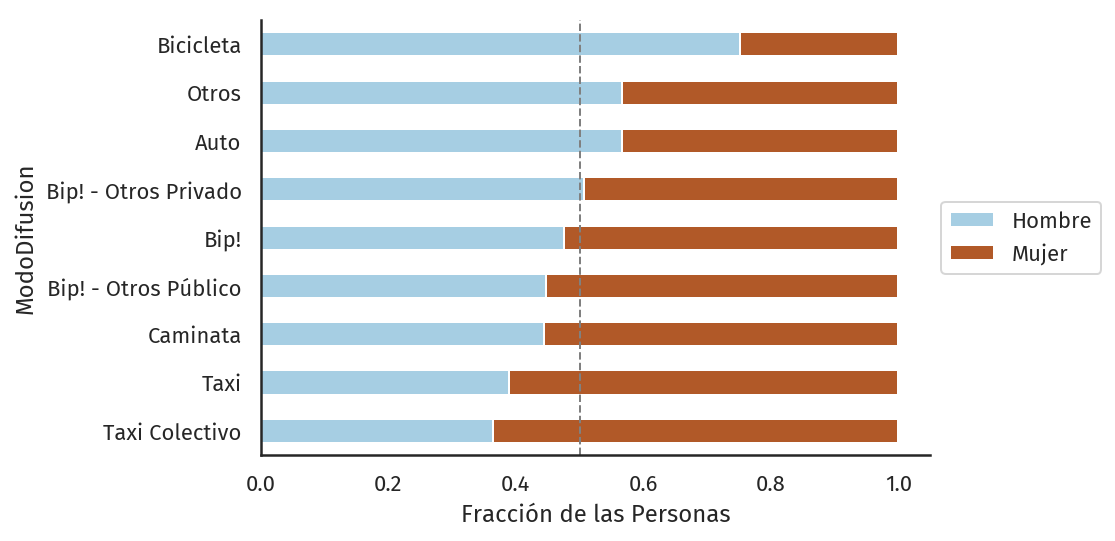

In [21]:
(viajes_persona.groupby(['ModoDifusion', 'Sexo'])
 .agg(n_viajes=('FactorPersona', 'sum'))
 ['n_viajes'].unstack(fill_value=0)
 .pipe(normalize_rows)
 .sort_values('Hombre')
 .plot(kind='barh', stacked=True, cmap='Paired'))

plt.axvline(x=0.5, color='grey', linestyle='dashed', linewidth=1)
plt.xlabel('Fracción de las Personas')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
sns.despine()

¿Se te ocurren otras preguntas utilizando estas técnicas?

---

## 3. Heatmaps y Slope Chart

Ahora exploraremos tareas que se pueden responder con _heatmaps_ y _slope charts_.

### ¿Quiénes no usan Transantiago y Por qué?

Para responder _quiénes_ nos fijaremos en la edad y el sexo de las personas.

Calculemos la edad y a partir de ella un grupo etáreo:

In [22]:
personas_hogar['Edad'] = 2013 - personas_hogar['AnoNac']

El método `pd.cut` nos permite asignarle una categoría a un grupo de filas de la tabla en función de límites especificados por nosotros. Por ejemplo:

In [23]:
personas_hogar['GrupoEtareo'] = pd.cut(personas_hogar['Edad'], [0, 18, 25, 35, 45, 55, 65, 120], right=False)
personas_hogar['GrupoEtareo'].value_counts()

[0, 18)      13068
[25, 35)      8575
[65, 120)     8317
[45, 55)      8256
[35, 45)      7942
[18, 25)      7297
[55, 65)      6599
Name: GrupoEtareo, dtype: int64

La encuesta tiene una columna llamada `NoUsaTransantiago` que será útil para nuestros efectos:

In [24]:
personas.NoUsaTransantiago.unique()

array(['G', 'H', 'B', 'E', nan, 'B;H', 'A;B', 'A', 'A;G', 'A;H', 'B;G',
       'B;C', 'C', 'G;H', 'F', 'C;G', 'B;F', 'C;F', 'D', 'A;D', 'A;C',
       'B;E', 'A;F', 'E;H', 'E;F', 'F;H', 'E;G', 'E;B', 'D;F', 'E;A',
       'B;A', 'D;H', 'D;E', 'F;A', 'A;E', 'F;G', 'D;G', 'C;H', 'B;D',
       'C;E', 'C;D', 'H;G', 'D;A', 'C;B', 'G;A', 'F;B', 'C;A', 'G;B'],
      dtype=object)

Como vemos, hay varios tipos de valores:
  
  - Una letra codifica un motivo (que podemos descodificar desde las tablas de parámetros).
  - Más de una letra, separadas por `;`, codifica múltiples motivos. Esto complica las cosas, porque nuestra función de decodificación no considera este caso. Afortunadamente `pandas` provee un método que nos ayudará con eso.
  - `nan`, es decir, un valor nulo. Hay personas que sí usan Transantiago, por lo que esa pregunta no aplica a ellas.
  
Para la decodificación utilizaremos el método `decode_column`, sin embargo, antes debemos decirle a `pandas` que hay más de una respuesta por persona. Para ello:

  1. Elegiremos las filas de la tabla que no tengan valores nulos.
  2. Convertiremos el texto `'C;E'` en una lista `['C', 'E']`.
  3. Repetiremos a cada persona que tenga más de un motivo, y le asignaremos un motivo único a cada repetición. 
  4. Decodificaremos la tabla con personas repetidas.
  5. Trabajaremos con la tabla decodificada.
  
Los pasos 1--3 los implementamos con los métodos `str.split` y `explode` de `pandas`:

In [25]:
no_usan_transantiago = (personas_hogar[pd.notnull(personas_hogar.NoUsaTransantiago)]
   .set_index('Persona')
   ['NoUsaTransantiago']
   .str.split(';')
   .explode()
   .reset_index())

no_usan_transantiago.head()

,Persona,NoUsaTransantiago
0,10001001,G
1,10001002,G
2,10001003,H
3,10002001,H
4,10002002,H


Ahora podemos decodificar la columna sin problemas:

In [26]:
no_usan_transantiago['NoUsaTransantiago'] = decode_column(no_usan_transantiago, path + '/Tablas_parametros/NoUsaTransantiago.csv', 'NoUsaTransantiago', index_dtype=str)
no_usan_transantiago['NoUsaTransantiago'].value_counts()

Utiliza transantiago, pero no lo utilizó el Día de Registro de Viaje por otras razones     21360
No lo utiliza por otra razón (especifique)                                                  9575
Baja frecuencia de los buses                                                                5671
Incómodo (los buses y/o metro van muy llenos)                                               4267
Hay que realizar muchas combinaciones (entre buses y/o Metro)                               2027
Poco seguro (asaltos, hurtos, etc)                                                          1700
Dificultad para calcular los tiempos de viaje (no sabe cuánto demorará en pasar el bus)     1515
Ninguna estación de Metro le queda cerca del origen o destino de sus viajes habituales       604
Name: NoUsaTransantiago, dtype: int64

El siguiente paso es que hay una categoría que no nos sirve: _Utiliza transantiago, pero no lo utilizó el Día de Registro de Viaje por otras razones_. Debemos descartarla:

In [27]:
irrelevante = 'Utiliza transantiago, pero no lo utilizó el Día de Registro de Viaje por otras razones'
no_usan_transantiago = no_usan_transantiago[no_usan_transantiago.NoUsaTransantiago != irrelevante]
len(no_usan_transantiago)

25359

El siguiente paso es restaurar los atributos socio-demográficos que nos interesan a la tabla que estamos trabajando. Lo podemos hacer con un `merge` y un subconjunto de las columnas de `personas_hogar`.

In [28]:
no_usan_transantiago = no_usan_transantiago.merge(personas_hogar[['Persona', 'Sector', 'GrupoEtareo', 'Edad', 'Sexo', 'FactorPersona']])
no_usan_transantiago.sample(5)

,Persona,NoUsaTransantiago,Sector,GrupoEtareo,Edad,Sexo,FactorPersona
3484,12135103,Baja frecuencia de los buses,Poniente,"[18, 25)",21,Hombre,92.18335
15402,20075001,No lo utiliza por otra razón (especifique),Extensión Sur-Poniente,"[55, 65)",62,Mujer,117.59481
15821,20409104,Incómodo (los buses y/o metro van muy llenos),Sur-Oriente,"[25, 35)",28,Hombre,231.79001
18075,22153104,Baja frecuencia de los buses,Sur-Oriente,"[18, 25)",23,Mujer,28.43724
20138,24363101,Baja frecuencia de los buses,Poniente,"[65, 120)",70,Hombre,93.51064


Finalmente podemos empezar a trabajar en nuestros gráficos. 

El siguiente gráfico muestra la relación entre motivo de no uso y grupo etáreo, mostrando, para cada motivo de no uso, la distribución de cada grupo etáreo:

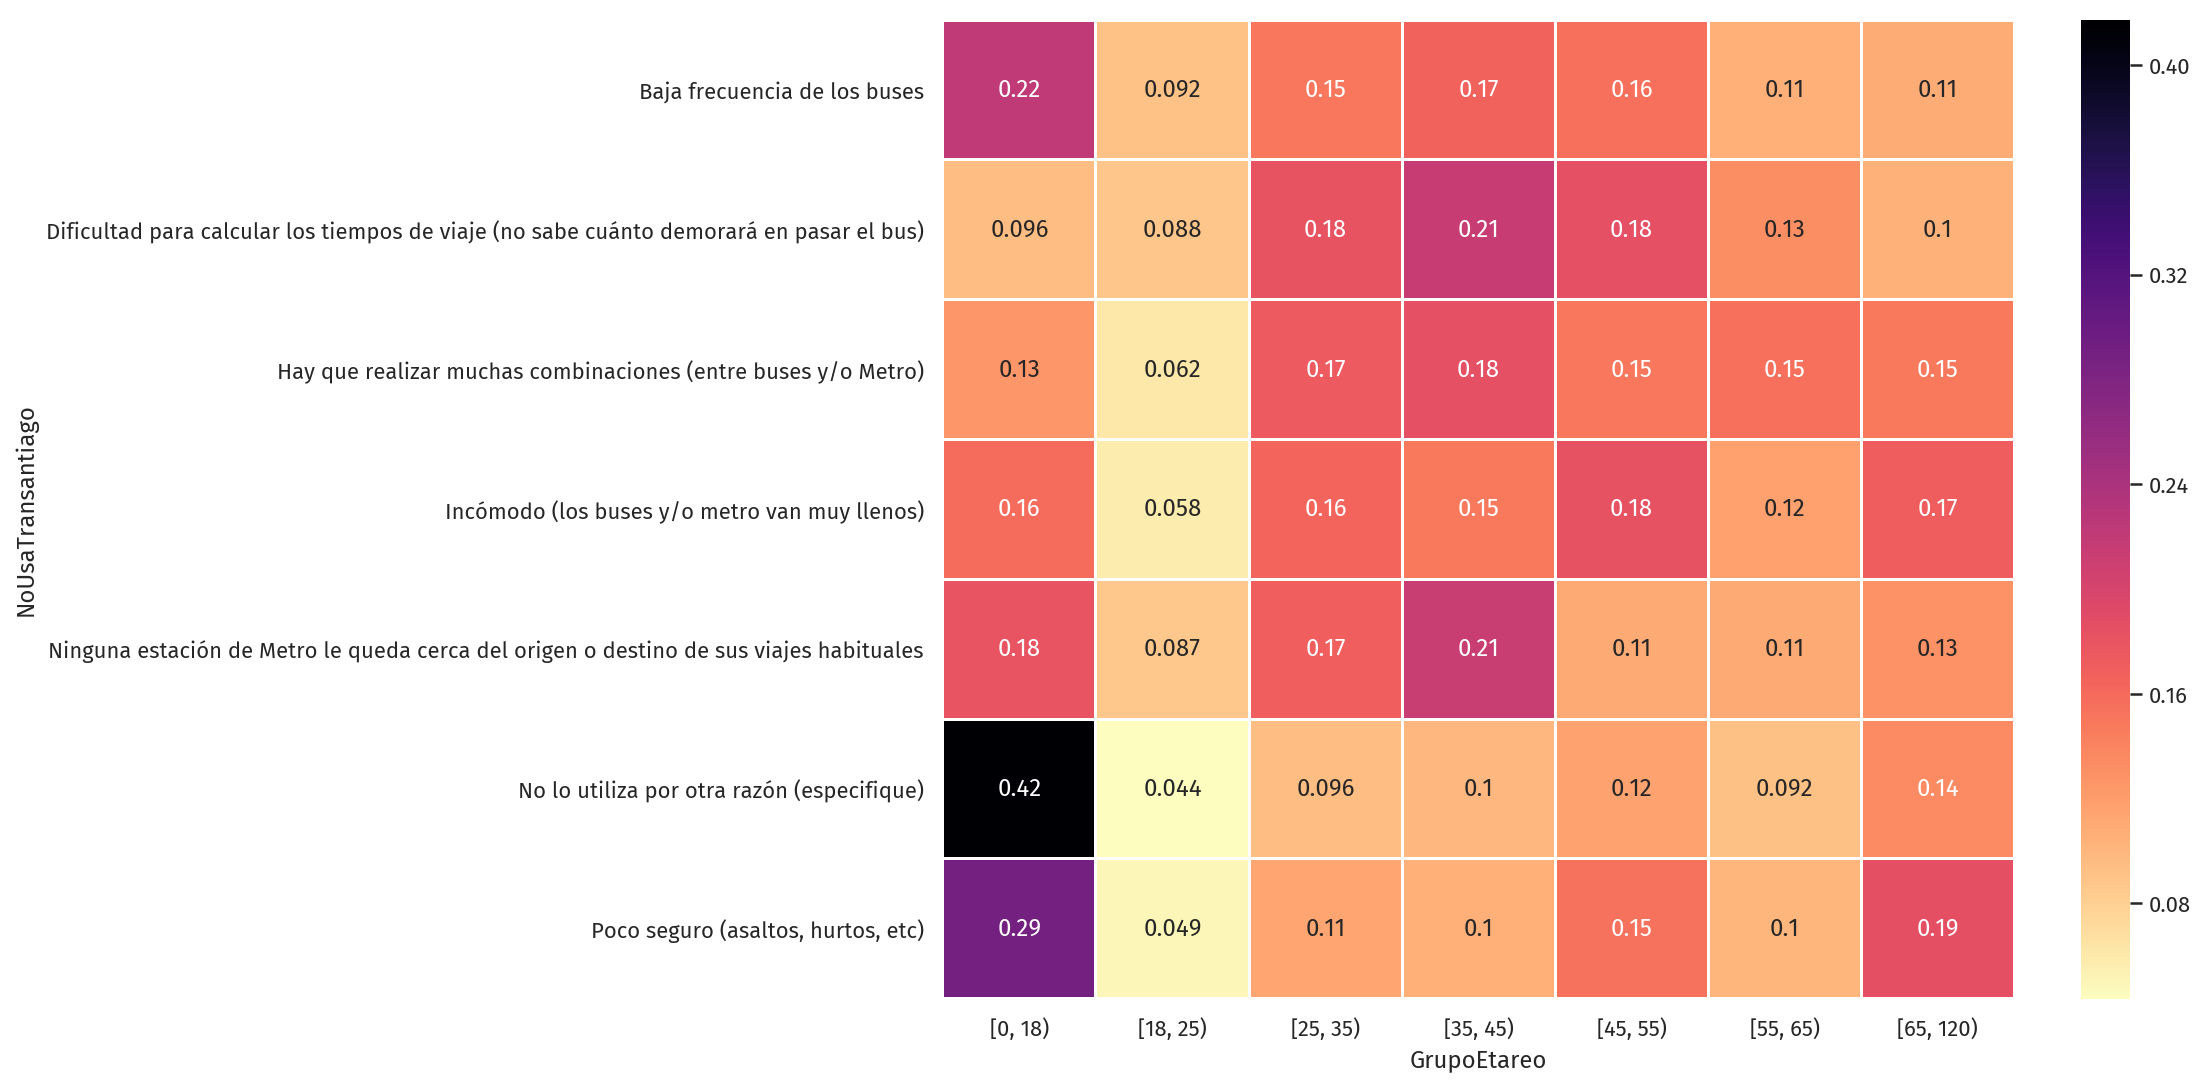

In [29]:
no_uso_por_edad = (no_usan_transantiago
 .groupby(['NoUsaTransantiago', 'GrupoEtareo'])
 .agg(n_personas=('FactorPersona', 'sum'))
 ['n_personas'].unstack(fill_value=0)
 .pipe(normalize_rows)
)

plt.figure(figsize=(12, 9))
sns.heatmap(no_uso_por_edad, linewidth=1, annot=True, cmap='magma_r')

Por ejemplo, vemos que:
  
  - el motivo de seguridad es particularmente relevante para menores de edad y gente jubulada.
  - el motivo de tiempos de viaje es particularmente relevante para edades que suelen trabajar (Entre 25 y 65 años).
  
¿Qué otras cosas ven en este gráfico?

Otra alternativa es utilizar el puntaje estándar. Quizás no nos interesa saber la distribución como tal, sino más bien si un par (grupo, motivo) se diferencia del promedio. Para eso podemos utilizar una función que calcule el puntaje estándar o _z-score_, que nos dice qué tan alejado un valor del promedio de los valores correspondientes:

In [30]:
def z_score_columns(df):
    return df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

Lo calcularemos por columnas. Como ya calculamos valores relativos para cada motivo, si calculamos valores relativos para cada grupo etáreo, entonces tendremos una aproximación respecto a los pares (grupo, motivo) más relevantes.

Esta función la podemos aplicar a la matriz que ya calculamos. Con el parámetro `center=0` le decimos a `sns.heatmap` que tendremos valores divergentes:

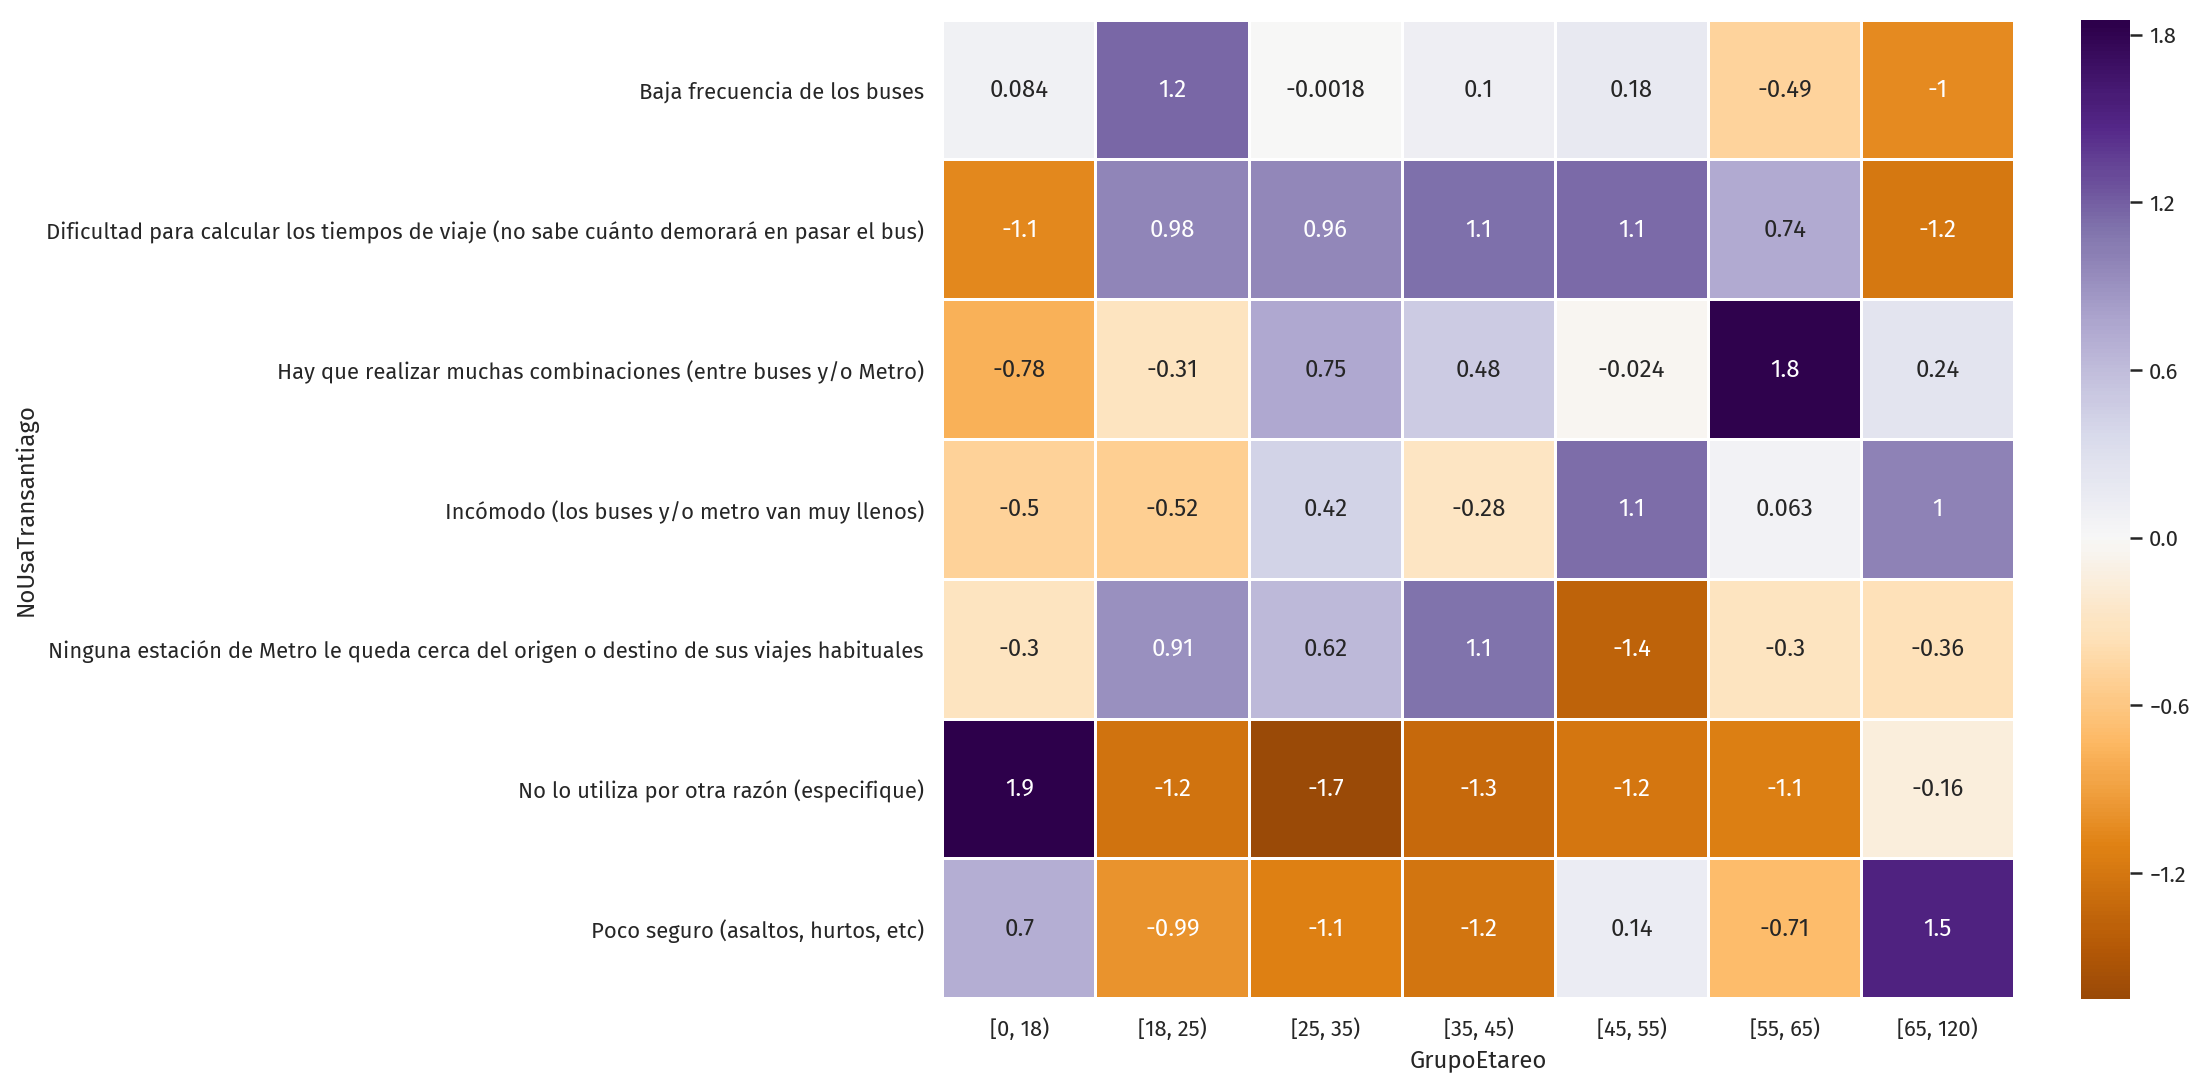

In [31]:
z_no_uso_por_edad = no_uso_por_edad.pipe(z_score_columns)

plt.figure(figsize=(12, 9))
sns.heatmap(z_no_uso_por_edad, linewidth=1, annot=True, cmap='PuOr', center=0)

Algunos resultados interesantes:

- No uso por "otro" es predominante en menores de edad. Esto se puede deber, por ejemplo, al uso de furgones escolares, o que alguien va a dejar a los niños al colegio.
- El motivo de cantidad de combinaciones afecta particularmente al grupo de 55 a 65 años.
- La dificultad de calcular tiempos de viaje afecta a todo el tramo que debe viajar por estudio o trabajo.
- El motivo de seguridad afecta principalmente a menores de edad y gente jubilada.

¿Hay otra conclusión interesante que puedan sacar de este gráfico?

#### Diferencias entre Hombres y Mujeres

Hagamos un ejercicio similar, pero considerando la variable `Sexo`. Si bien podríamos usar un _heatmap_ para esto, tenemos solamente dos grupos demográficos. Tenemos más espacio que podemos aprovechar para mostrar, por ej., las diferencias entre proporciones asignadas a cada motivo de no uso.

Analicemos a la población mayor de 18 años, ya que podemos estar más segures de que eligen su modo de transporte:

In [32]:
no_uso_por_sexo = (no_usan_transantiago[no_usan_transantiago['Edad'] >= 18]
 .groupby(['Sexo', 'NoUsaTransantiago'])
 .agg(fraccion=('FactorPersona', 'sum'))
 ['fraccion'].unstack(fill_value=0)
 .pipe(normalize_rows)
 .stack()
 .reset_index()
 # se perdió el nombre de la columna al hacer stack
 .rename(columns={0: 'fraccion'}))

no_uso_por_sexo

,Sexo,NoUsaTransantiago,fraccion
0,Hombre,Baja frecuencia de los buses,0.207621
1,Hombre,Dificultad para calcular los tiempos de viaje ...,0.092215
2,Hombre,Hay que realizar muchas combinaciones (entre b...,0.105067
3,Hombre,Incómodo (los buses y/o metro van muy llenos),0.215193
4,Hombre,Ninguna estación de Metro le queda cerca del o...,0.029057
5,Hombre,No lo utiliza por otra razón (especifique),0.302755
6,Hombre,"Poco seguro (asaltos, hurtos, etc)",0.048092
7,Mujer,Baja frecuencia de los buses,0.222929
8,Mujer,Dificultad para calcular los tiempos de viaje ...,0.078252
9,Mujer,Hay que realizar muchas combinaciones (entre b...,0.097486


En clases dijimos que un _line chart_ no es buena idea cuando el atributo llave (usualmente en el eje x) es categórico, ya que puede llegar a interpretaciones erróneas.

Existe un tipo de gráfico llamado _Slope Chart_ que no sigue esa recomendación. Porque no solamente nos interesa ver la magnitud de cada categoría, sino también su posición relativa. De cierto modo, un _slope chart_ es un caso especial de lo que vimos como _Parallel Coordinates_.

Podemos hacerlo con `sns.catplot`:

Text(104.184,0.5,'Fracción de las Personas')

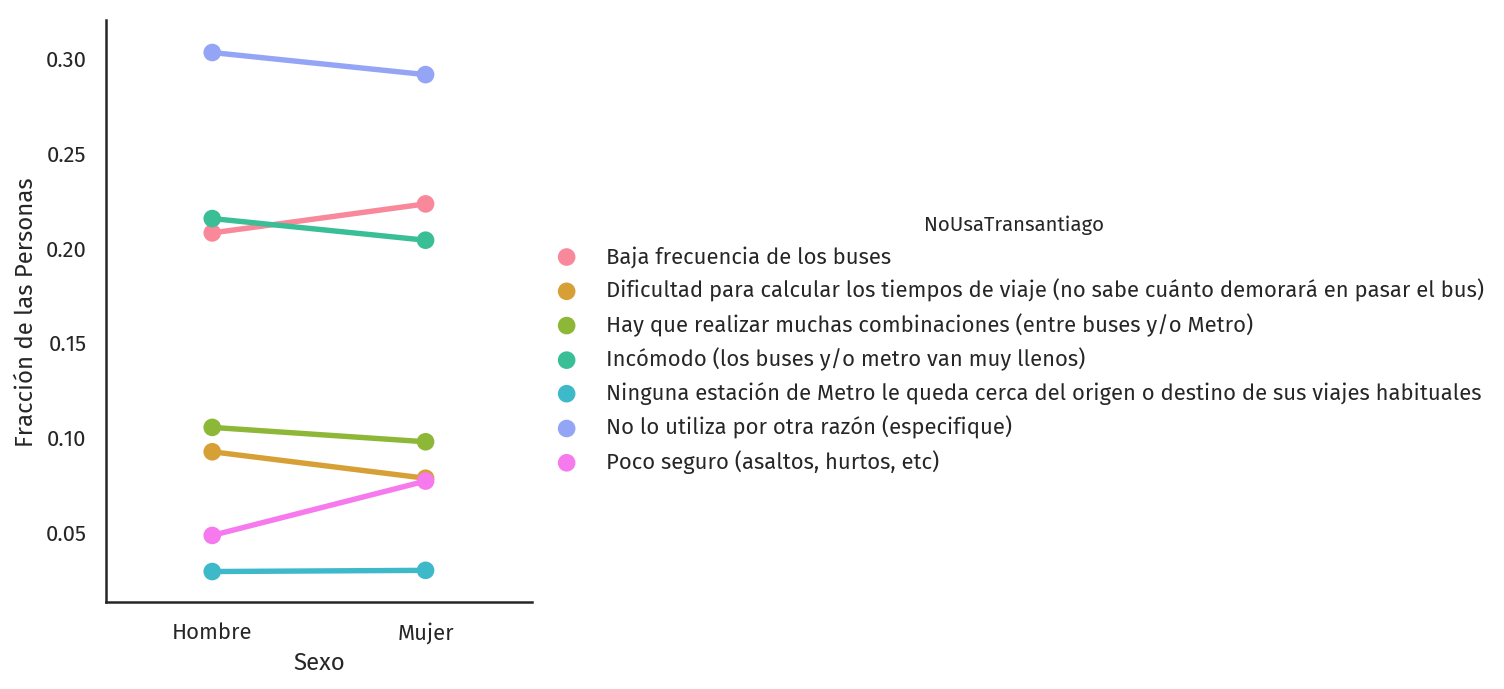

In [33]:
sns.catplot(x='Sexo', y='fraccion', hue='NoUsaTransantiago', data=no_uso_por_sexo, kind='point')
plt.ylabel('Fracción de las Personas')

---

## Flujos entre comunas

Una pregunta que podemos hacernos es encontrar los flujos entre comunas. ¿De dónde hacia dónde se mueve la gente? Podemos aprovechar las operaciones que hemos visto hasta ahora para calcular una matriz de flujos:

In [34]:
flujos = (viajes_persona[pd.notnull(viajes_persona.PesoLaboral) &
                         (viajes_persona.PropositoAgregado.isin(['Estudio', 'Trabajo']))]
          .groupby(['ComunaOrigen', 'ComunaDestino'])
          .agg(n_viajes=('PesoLaboral', 'sum'))
          ['n_viajes'].unstack(fill_value=0)
          .pipe(normalize_rows))

flujos.sample(3)

ComunaDestino,Calera de Tango,Cerrillos,Cerro Navia,Colina,Conchalí,El Bosque,Estación Central,Huechuraba,Independencia,La Cisterna,...,Quinta Normal,Recoleta,Renca,San Bernardo,San Joaquín,San Miguel,San Ramón,Santiago,Vitacura,Ñuñoa
ComunaOrigen,,,,,,,,,,,,,,,,,,,,,
Lampa,0.0,0.000000,0.000960,0.039911,0.023446,0.000000,0.000000,0.003377,0.011834,0.000000,...,0.000000,0.021366,0.000000,0.000000,0.000000,0.000000,0.000000,0.149978,0.000000,0.007064
Ñuñoa,0.0,0.010226,0.000000,0.000268,0.000607,0.000177,0.012937,0.016611,0.002519,0.002192,...,0.000644,0.011248,0.000000,0.010734,0.009244,0.007219,0.003577,0.248132,0.008037,0.189987
Las Condes,0.0,0.002076,0.000221,0.000344,0.000137,0.003793,0.008699,0.017864,0.005845,0.001678,...,0.005471,0.010483,0.007594,0.002085,0.004434,0.007187,0.000000,0.159158,0.070462,0.029726


Al ser una matriz, podemos utilizar `sns.heatmap` para visualizarla:

Text(0.5,1,'Matriz Origen-Destino de Viajes (día laboral, al estudio / al trabajo)')

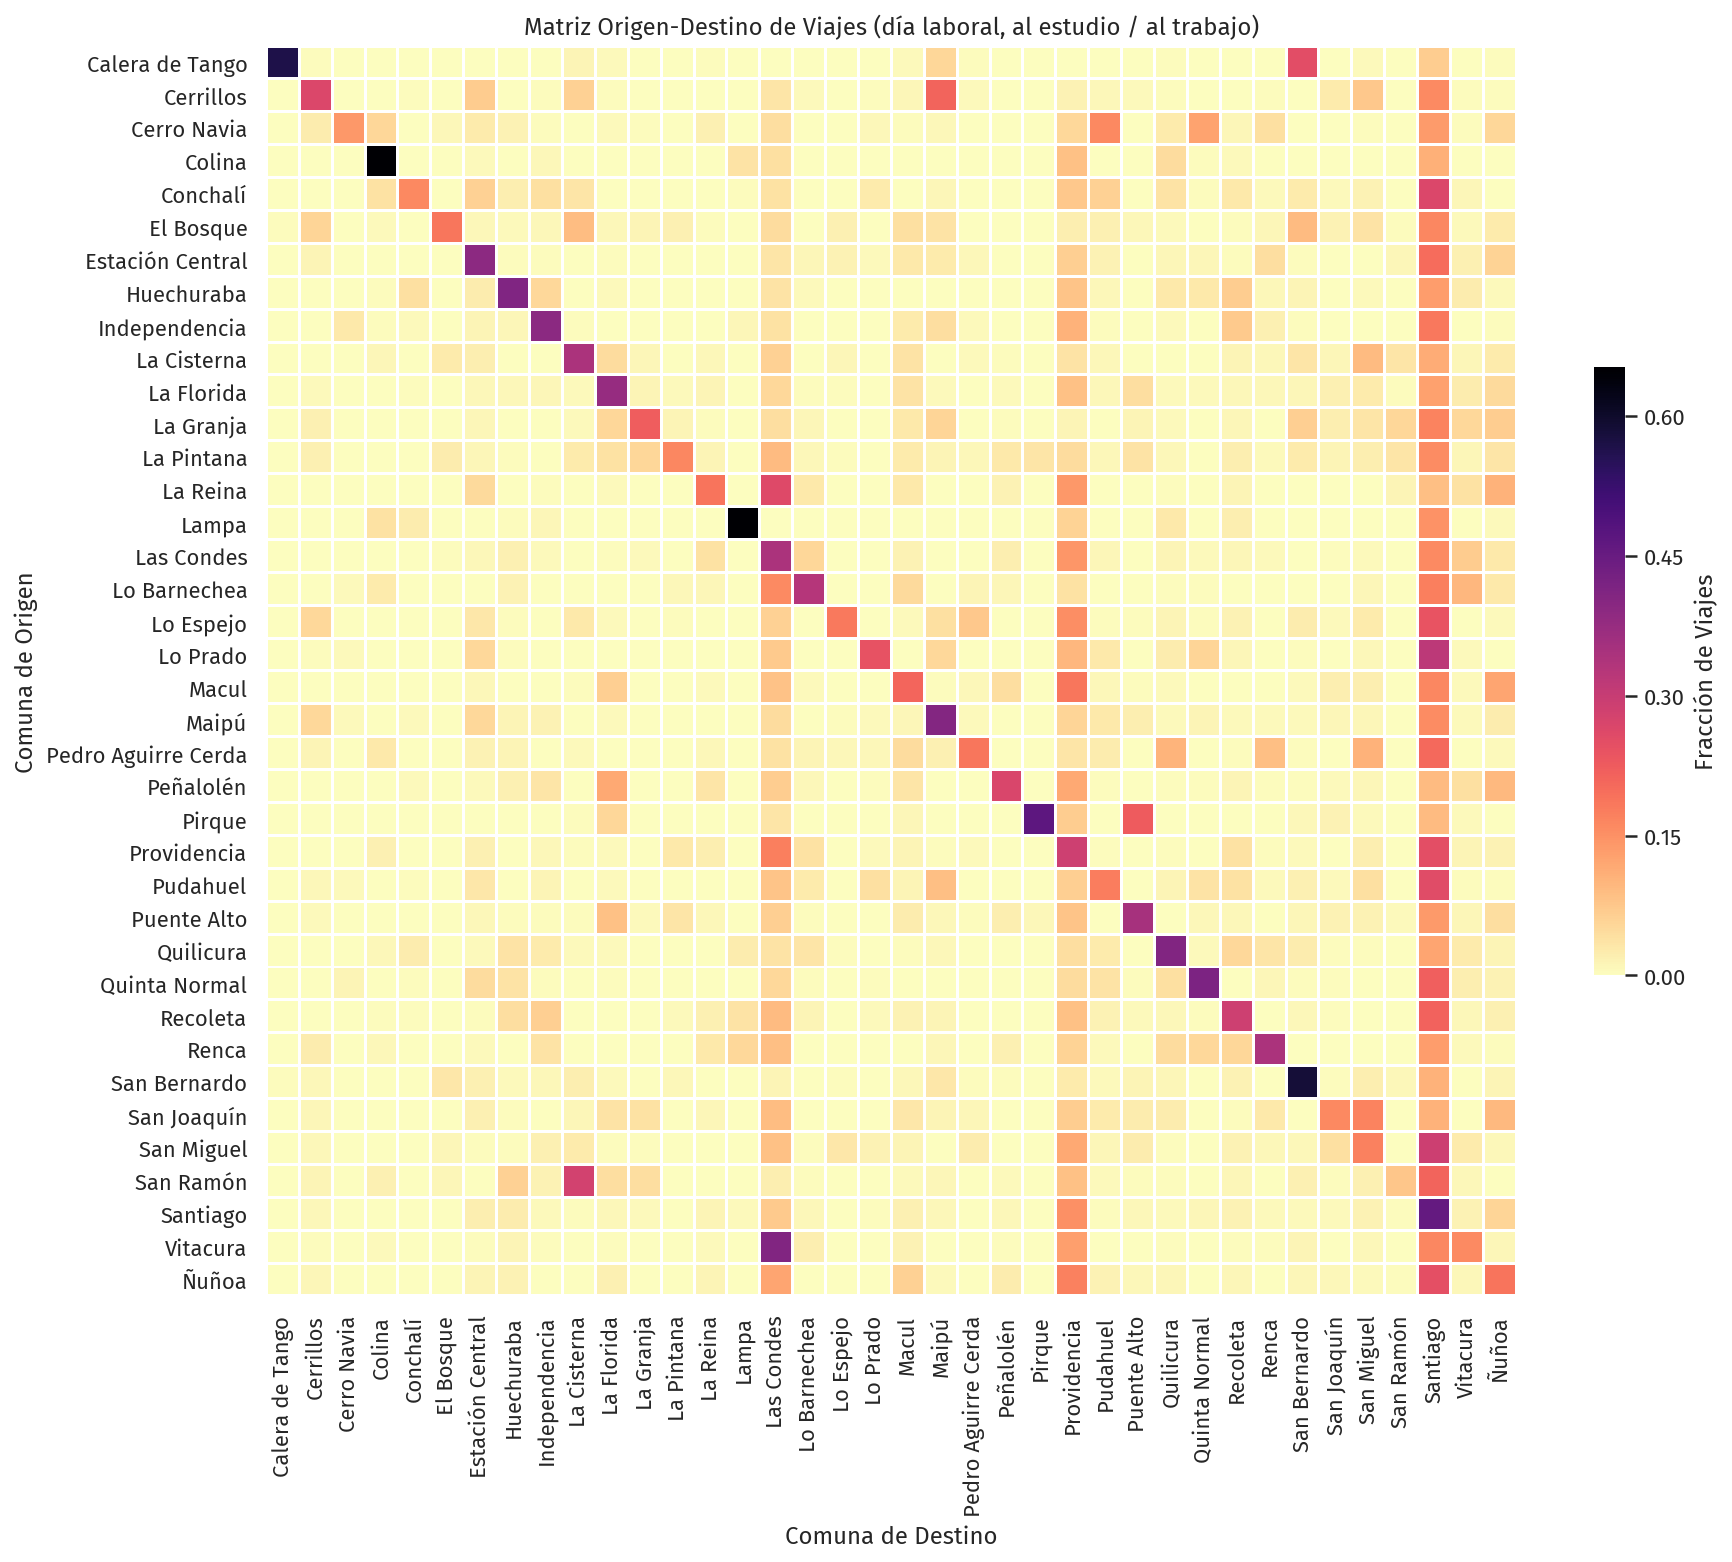

In [36]:
plt.figure(figsize=(14, 14))
sns.heatmap(flujos, cmap='magma_r', square=True, linewidths=1, 
            cbar_kws={'shrink': 0.4, 'label': 'Fracción de Viajes'})
plt.xlabel('Comuna de Destino')
plt.ylabel('Comuna de Origen')
plt.title('Matriz Origen-Destino de Viajes (día laboral, al estudio / al trabajo)')

En esta matriz vemos que hay dos tipos de patrones marcados:

- Los viajes por trabajo o estudio dentro de la misma comuna son frecuentes.
- Existen tres comunas que concentran viajes: Las Condes, Providencia, y Santiago.

¿Ven otros patrones relevantes? ¿Cómo se vería la matriz para otros propósitos de viaje?

---

## Conclusiones

En este notebook empezamos a utilizar los factores de expansión y técnicas más avanzadas de `pandas` para analizar los datos. Seguimos utilizando la biblioteca `seaborn` como base, apoyándonos en `pandas` para algunos gráficos.

Esta encuesta tiene muchísimas variables interesantes por analizar. Les invito a contribuir preguntas interesantes para responder utilizando las técnicas de visualización de tablas vistas en clase.